In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings

from scipy.special import logsumexp 
from utils.brains import *
from utils.model import subj
from m0_preprocess import remake_cols_idx

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [11]:
def sim( brain, sub_idx, seed=2014, data_set='rew_data_exp1'):

    # fix random seed
    np.random.seed( seed)

    # get the data 
    dname = f'data/data_raw_exp1/behavioral_trial_table_{sub_idx}_rew_modelready.csv'
    task = { '{sub_idx}': remake_cols_idx(pd.read_csv( dname), sub_idx, '')}

    # define the RL2 model 
    model = subj( eval(brain))

    # if there is no input parameter,
    # choose the best model,
    # the last column is the loss which is ignored
    fname = f'results/params-{data_set}-{brain}-avg.csv'
    params = pd.read_csv( fname, index_col=0).iloc[0, 0:-1].values
    print(pd.read_csv( fname, index_col=0).iloc[0, :])
    
    # synthesize the data and save
    return model.pred( params, task)    

In [12]:
def plot_sim( sim_data):

    # get the trials
    trials  = sim_data['trial'].values
    outcome = sim_data['state'].values
    NLLs    = sim_data['nll'].values
    tot_NLL = sim_data['nll'].values.sum()
    b1_NLL = sim_data['nll'].values[:90].sum()
    b2_NLL = sim_data['nll'].values[90:].sum()
    
    # get the true prob 
    p1 = np.sum(sim_data.loc[ :90, 'state'] == 0) / 90 
    p2 = np.sum(sim_data.loc[ 90:, 'state'] == 0) / 90 
    if sim_data['b_type'][0]:
        p1 = [p1] * 90
        if p2 > .5:
            p2 = [.8]*20+[.2]*20+[.8]*20+[.2]*20+[.8]*10
        else:
            p2 = [.2]*20+[.8]*20+[.2]*20+[.8]*20+[.2]*10
    else:
        p2 = [p2] * 90
        if p1 > .5:
            p1 = [.8]*20+[.2]*20+[.8]*20+[.2]*20+[.8]*10
        else:
            p1 = [.2]*20+[.8]*20+[.2]*20+[.8]*20+[.2]*10
    
    # get the human response 
    p         = sim_data['p_s'] 
    human_act = -1 * ((sim_data['human_act'].values == 1) * 2 - 1)
    sim_act   = -1 * ((sim_data['action'].values == 1) * 2 - 1)
    prob_act  = sim_data['act_acc'].values * sim_act
    human_a1  = sim_data['human_act'].values == 0
    avg_a1    = [np.sum(human_a1[:90]) / 90] * 90 + [np.sum(human_a1[90:]) / 90] * 90

    my_dpi = 150
    plt.figure( figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)

    plt.subplot( 3, 1, 1)
    plt.plot( trials, p1 + p2, color=[.6, .6, .6])
    plt.plot( trials, p, color='r')
    plt.title( f'NLL: {tot_NLL:.3f}; block 1: {b1_NLL:.3f}; block 2: {b2_NLL:.3f}')
    
    plt.subplot( 3, 1, 2)
    plt.bar( trials, human_act, color=[.6, .6, .6])
    plt.plot( trials, prob_act, color='r')

    plt.subplot( 3, 1, 3)
    plt.plot( trials, NLLs, color=[.6, .6, .6])
    plt.ylim( [ 0, 2.5])
    # plt.scatter( trials, human_a1, color='b')
    # plt.plot( trials, avg_a1, color='b')



In [13]:
sub_id = 'n25'

α_s_stab       0.297109
α_s_vol        0.368207
α_a            0.089657
β              3.113305
mle_loss    8366.001565
Name: 0, dtype: float64


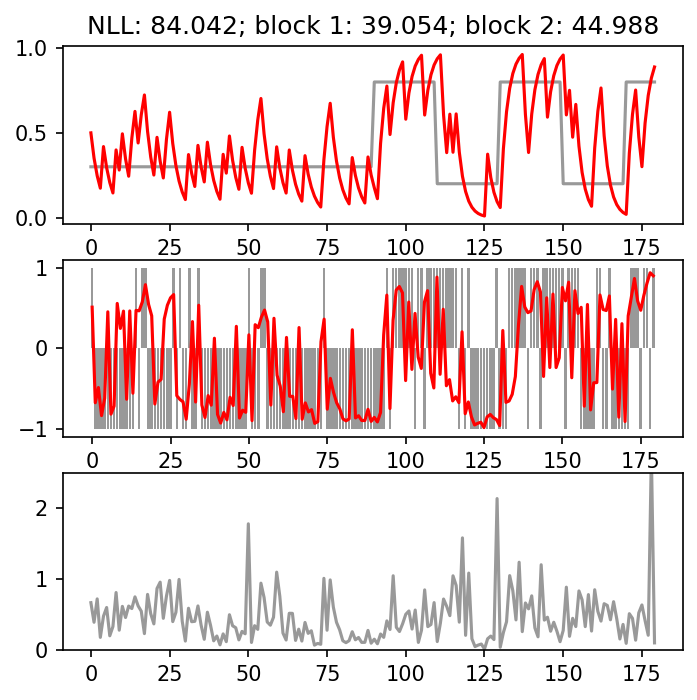

In [14]:
plot_sim(sim( 'RRmodel', sub_id, seed=1234))

α_s_stab       0.454006
α_s_vol        0.570806
λ              0.433323
r              0.669091
α_a            0.236297
β              2.554553
β_a            1.286858
mle_loss    8029.110901
Name: 0, dtype: float64


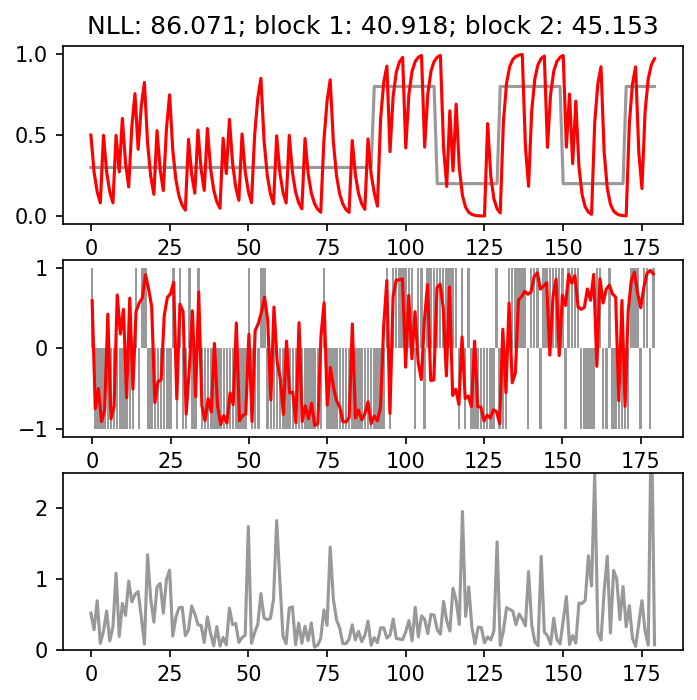

In [15]:
plot_sim(sim( 'model11', sub_id, seed=1234))

λ              0.919026
r              0.723880
α_a            0.283989
β             17.132068
β_a            1.558496
mle_loss    8748.995071
Name: 0, dtype: float64


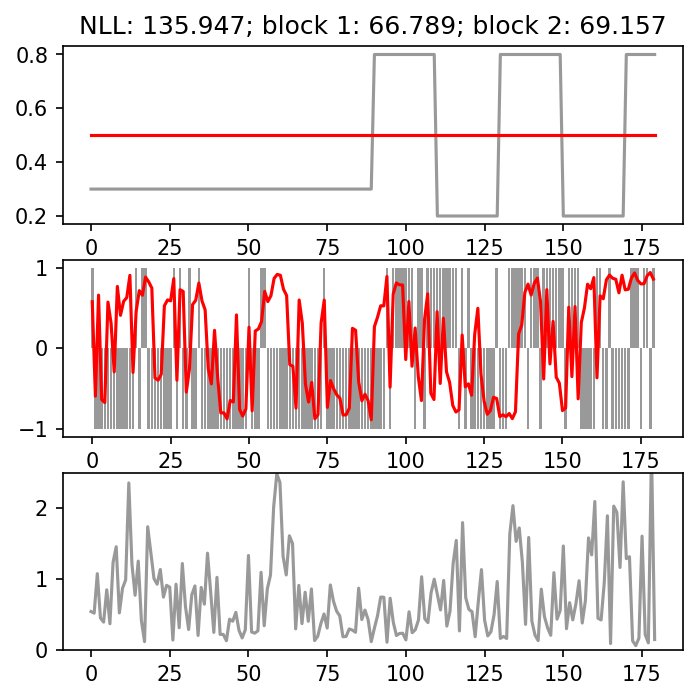

In [16]:
plot_sim(sim( 'model11_m', sub_id, seed=1234))

α_s_stab       0.193486
α_s_vol        0.328397
λ              0.487108
β              3.298704
mle_loss    8717.073269
Name: 0, dtype: float64


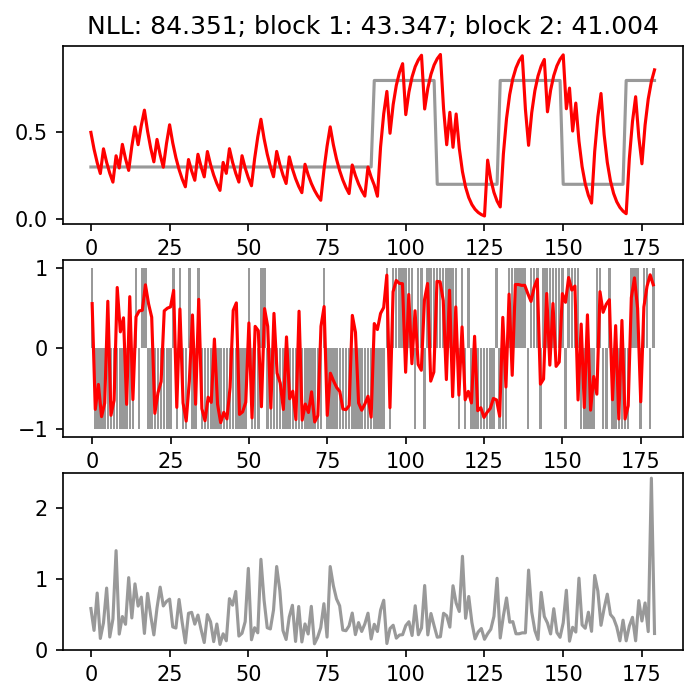

In [8]:
plot_sim(sim( 'model2', sub_id, seed=1234))

α_s_stab       0.202587
α_s_vol        0.332132
γ              1.238792
β              3.406868
mle_loss    8809.773043
Name: 0, dtype: float64


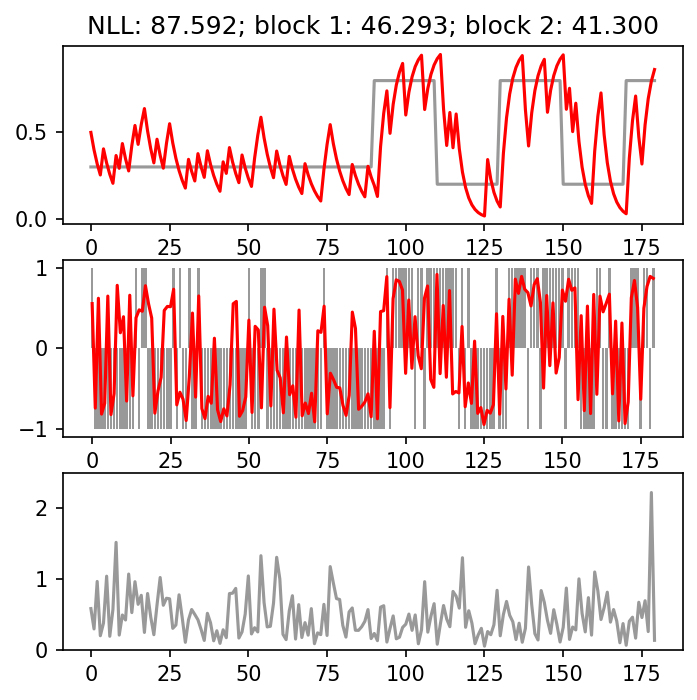

In [9]:
plot_sim(sim( 'model1', sub_id, seed=1234))

In [5]:
plot_sim(sim( 'max_mag', sub_id, seed=1234))

β              2.300000
mle_loss    8444.334961
Name: 0, dtype: float64


ValueError: 'a' and 'p' must have same size

In [30]:
def m11( p, M):
    m1, m2 = M 
    r = .64 
    lamb = .47
    m_diff = np.abs(m1 - m2) 
    return lamb * ( 2 * p - 1) + ( 1 - lamb) * np.sign(m1 - m2) * m_diff ** r 
    
def rr( p, M):
    m1, m2 = M 
    Q = np.array([[ m1,    0],
                  [    0, m2]])
    ps = np.array([[ p, 1-p]]).T
    vals = ps.T @ Q # 1s ss = 1s
    return vals[ 0, 0] - vals[ 0, 1]

In [31]:
def explore_val( model):
    p_lst = np.linspace( .01, 1, 8)
    M1 = np.arange( 10, 100, 10)
    M_pairs = [ (m1, 100-m1) for m1 in M1]
    my_dpi = 150
    plt.figure( figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    for i, p in enumerate(p_lst):
        lst = []
        plt.subplot( len(p_lst), 1, i+1)
        for M in M_pairs:
            lst.append(eval(model)( p, M))
        plt.plot( M1, lst, color='r')
        if model == 'm11':
            plt.ylim( [ -10, 10])
        elif model == 'rr':
            plt.ylim( [ -100, 100])
        

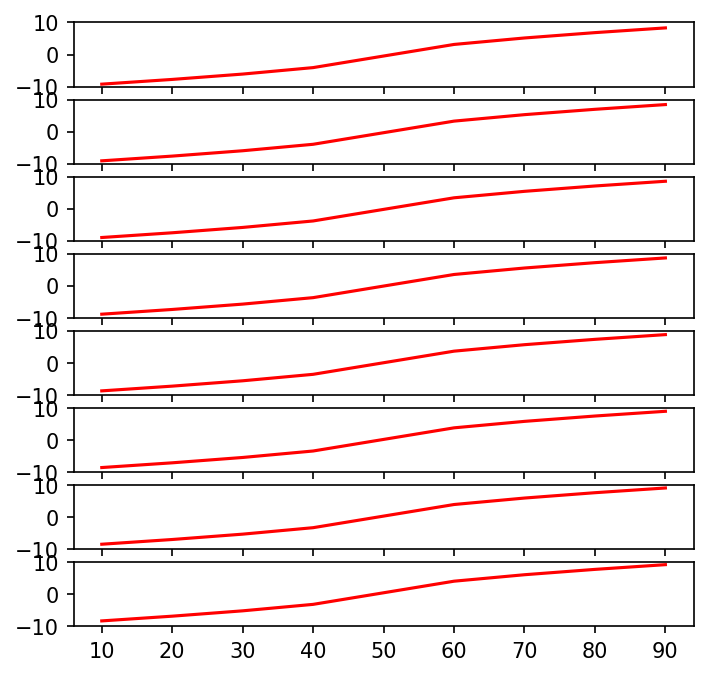

In [16]:
explore_val( 'm11')

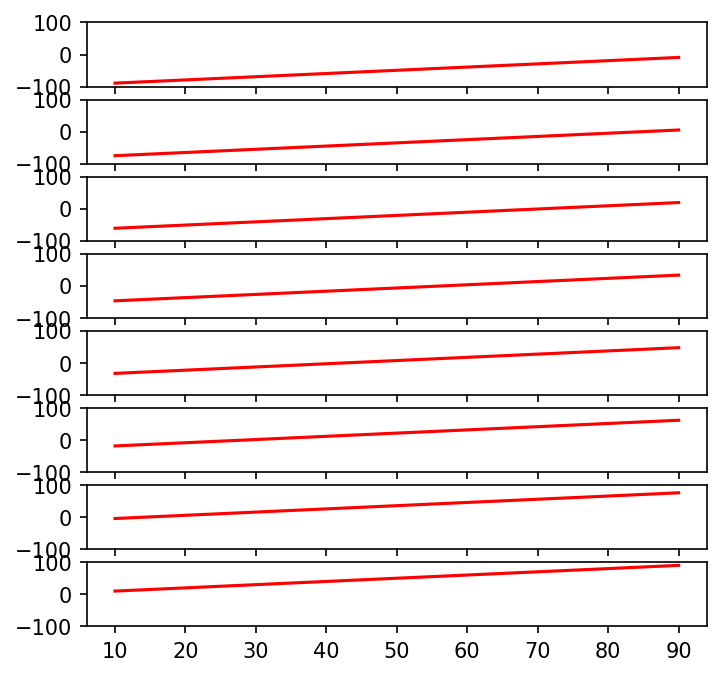

In [17]:
explore_val( 'rr')

In [71]:
def vis_p( gamma, F):
    gn = len(gamma)
    sn = 40
    ps    = np.linspace( .0, 1, sn)
    mat = np.zeros( [ len(ps), len(gamma),])
    lg = []
    for gi, g in enumerate( gamma):
        lg.append( f'$\gamma$ = {g:.2f}')
        for pi, p in enumerate( ps):
            mat[ pi, gi] = F(g,p)
    my_dpi = 200
    plt.figure( figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    alphas = np.linspace( 0, .8, gn) 
    for i, a in enumerate(alphas):
        if i ==2:
            c = 'r'
        else:
            c  = 'b'
        plt.plot( ps, mat[ :, i], color=c, alpha=(.2+a))
    plt.xlabel( '$p_t$')
    plt.ylabel( '$p\'_t$')
    plt.legend( lg)


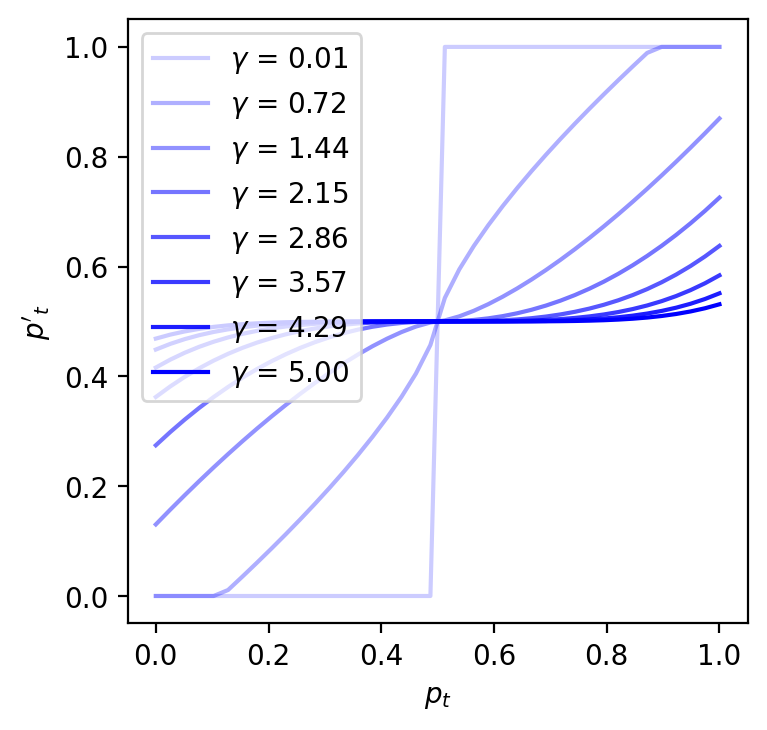

In [76]:
def F1( g, p):
    return np.min( [ np.max( [np.sign(p-.5) * abs(p - .5) ** g + .5, 0]), 1])
gn = 8
gamma = np.linspace( .01, 5, gn)
vis_p( gamma, F1)

<ipython-input-75-a246c93e2427>:2: RuntimeWarning: divide by zero encountered in log
  return np.exp( -(-np.log(p) )** g)


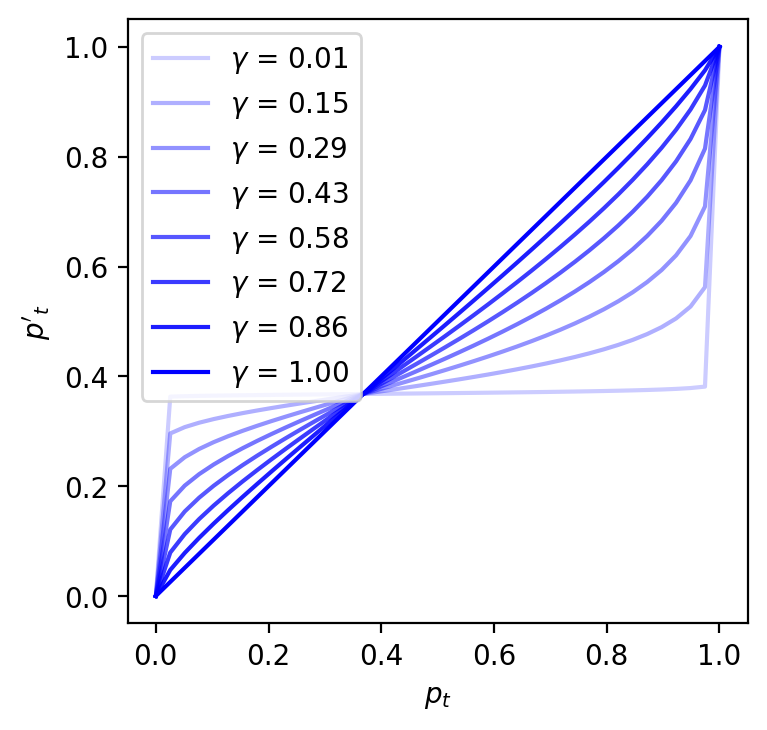

In [75]:
def F2( g, p):
    return np.exp( -(-np.log(p) )** g)
gn = 8
gamma = np.linspace( .01, 1, gn)
vis_p( gamma, F2)